In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
from keras import optimizers


# from sklearn.cross_validation import KFold
from sklearn.metrics import fbeta_score
from sklearn.utils import shuffle

from keras.preprocessing.image import ImageDataGenerator

In [3]:
x_train = []
y_train = []

df_train = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [33]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in df_train['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'habitation', 'road', 'cloudy', 'conventional_mine', 'bare_ground', 'blooming', 'blow_down', 'haze', 'primary', 'water', 'selective_logging', 'artisinal_mine', 'cultivation', 'clear', 'agriculture', 'slash_burn', 'partly_cloudy'}


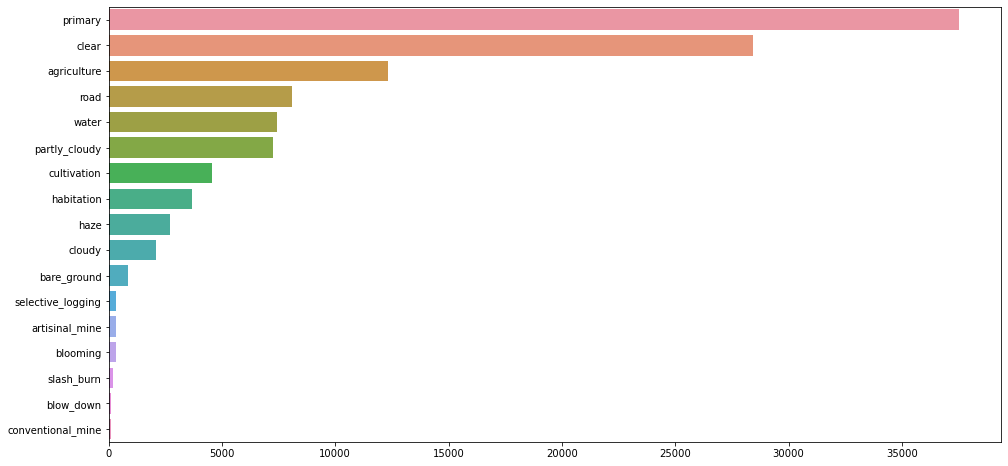

In [36]:
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [4]:
sample = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [5]:
df_test = sample[:40669]

df_test_extra = sample[40669:]

In [6]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

In [7]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (64, 64)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [01:47<00:00, 377.18it/s]


(40479, 64, 64, 3)
(40479, 17)


In [8]:
test = []
for f in tqdm(df_test.image_name.values, miniters=1000):
    img_test = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(f))
    test.append(cv2.resize(img_test, (64, 64)))
    
for f in tqdm(df_test_extra.image_name.values, miniters=1000):
    img_test2 = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(f))
    test.append(cv2.resize(img_test2, (64, 64)))
    
X_test = np.array(test, np.float16) / 255.

print(X_test.shape)

100%|██████████| 20522/20522 [00:52<00:00, 389.67it/s]


(61191, 64, 64, 3)


In [9]:
import numpy as np
from sklearn.metrics import fbeta_score

def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(17):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.2]*17
    for i in range(17):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
                best_score = score
            
        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x

In [10]:
split = 35000

x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]



In [11]:
image_gen = ImageDataGenerator(vertical_flip=True, zoom_range=0.2,
    rotation_range=90,
    fill_mode = 'reflect',
    horizontal_flip=True)

In [12]:
model2_weights_path = os.path.join('', 'model2_weights.h5')

from keras.applications.vgg19 import VGG19
base_model2=VGG19(include_top=False,
               weights='imagenet',
               input_shape=(64, 64, 3))

model2 = Sequential()
model2.add(BatchNormalization(input_shape=(64, 64, 3)))
model2.add(base_model2)
model2.add(Flatten())
# I don't use 4096 Dense layer because it might get higher score on LB.
# Source: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/36091#202629
# model2.add(Dense(4096, activation='relu'))
# model2.add(Dropout(0.5))
#model.add(Dense(4096, activation='relu'))
model2.add(Dense(17, activation='sigmoid'))

80142336/80134624 [==============================] - 0s 0us/step


In [13]:
from keras.callbacks import ReduceLROnPlateau

In [14]:
from keras.optimizers import Adam

In [16]:
callbacks2 = [
            EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
            ModelCheckpoint(model2_weights_path, monitor='val_loss', save_best_only=True, verbose=1)]

In [17]:
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [18]:
import gc
gc.collect()

20

In [20]:
history2 = model2.fit_generator(image_gen.flow(x_train, y_train,batch_size=128),
                              steps_per_epoch=x_train.shape[0]/128, 
          validation_data=image_gen.flow(x_valid, y_valid, batch_size=128),
                              validation_steps=x_valid.shape[0]/128, epochs=25,
                              verbose=2,callbacks=callbacks2,shuffle=True)

Epoch 1/25

Epoch 00001: val_loss improved from inf to 0.14251, saving model to model2_weights.h5
274/273 - 54s - loss: 0.1423 - accuracy: 0.6334 - val_loss: 0.1425 - val_accuracy: 0.6379
Epoch 2/25

Epoch 00002: val_loss improved from 0.14251 to 0.11445, saving model to model2_weights.h5
274/273 - 54s - loss: 0.1146 - accuracy: 0.6375 - val_loss: 0.1144 - val_accuracy: 0.6665
Epoch 3/25

Epoch 00003: val_loss improved from 0.11445 to 0.10530, saving model to model2_weights.h5
274/273 - 53s - loss: 0.1095 - accuracy: 0.6589 - val_loss: 0.1053 - val_accuracy: 0.6700
Epoch 4/25

Epoch 00004: val_loss improved from 0.10530 to 0.10103, saving model to model2_weights.h5
274/273 - 53s - loss: 0.1056 - accuracy: 0.6557 - val_loss: 0.1010 - val_accuracy: 0.6468
Epoch 5/25

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00005: val_loss did not improve from 0.10103
274/273 - 54s - loss: 0.1028 - accuracy: 0.6599 - val_loss: 0.1031 - val_accuracy: 0.6689
Ep

In [ ]:
del x_train, y_train

gc.collect()

In [22]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss Curves - With Reularization - Model2')

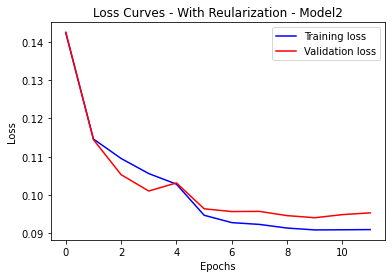

In [23]:
plt.figure()
plt.plot(history2.history['loss'], 'blue')
plt.plot(history2.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - With Reularization - Model2')

In [26]:
model2.load_weights(model2_weights_path)
p_valid2 = model2.predict(x_valid, batch_size = 64, verbose=2)
print(fbeta_score(y_valid, np.array(p_valid2) > 0.2, beta=2, average='samples'))
print("Optimizing prediction threshold for model 2")
print(optimise_f2_thresholds(y_valid, p_valid2))

86/86 - 2s
0.916381275288099
Optimizing prediction threshold for model 2
0 0.21 0.9164914446584674
1 0.27 0.91657613114685
2 0.05 0.9191683401461036
3 0.08 0.9191854866853313
4 0.11 0.9196981120540434
5 0.29 0.9199277537898906
6 0.11 0.9199283391315642
7 0.07 0.9207603833250082
8 0.5 0.9214772250376643
9 0.2 0.9214772250376643
10 0.35 0.921684951206998
11 0.07 0.9217829365224308
12 0.2 0.9217829365224308
13 0.31 0.9221409019218297
14 0.23 0.9223051872623962
15 0.17 0.9223421248335553
16 0.12 0.9223774396960619
[0.21, 0.27, 0.05, 0.08, 0.11, 0.29, 0.11, 0.07, 0.5, 0.2, 0.35, 0.07, 0.2, 0.31, 0.23, 0.17, 0.12]


In [ ]:
gc.collect()

In [27]:
pred2 = model2.predict(X_test, batch_size=128)

In [28]:
full_test2 = []
full_test2.append(pred2)
result2 = np.array(full_test2[0])
result2 = pd.DataFrame(result2, columns = labels)
result2.head()

,habitation,road,cloudy,conventional_mine,bare_ground,blooming,blow_down,haze,primary,water,selective_logging,artisinal_mine,cultivation,clear,agriculture,slash_burn,partly_cloudy
0,0.003947,0.003417,0.000015,2.452344e-06,0.000206,0.055819,0.002328,0.000172,0.999971,0.003822,0.004301,0.000003,0.003939,0.996636,0.010479,0.000106,0.003116
1,0.003133,0.002273,0.000005,8.749188e-07,0.000107,0.096580,0.002980,0.000027,0.999993,0.002056,0.006015,0.000001,0.003066,0.998144,0.008411,0.000078,0.002078
2,0.000635,0.007211,0.000439,3.763623e-06,0.000032,0.000127,0.000239,0.000282,0.999781,0.030040,0.000157,0.000008,0.003901,0.000285,0.014277,0.000023,0.998697
3,0.004551,0.050346,0.000037,1.048297e-04,0.004773,0.007615,0.003429,0.002133,0.999938,0.119014,0.004828,0.000135,0.259798,0.898975,0.673511,0.003268,0.135443
4,0.006169,0.034924,0.126014,5.832958e-05,0.000530,0.000201,0.000383,0.002792,0.887344,0.069481,0.000221,0.000075,0.012978,0.001078,0.043735,0.000131,0.887541


In [29]:
thres2 = [0.21, 0.27, 0.05, 0.08, 0.11, 0.29, 0.11, 0.07, 0.5, 0.2, 0.35, 0.07, 0.2, 0.31, 0.23, 0.17, 0.12]
prediction2 = []
for i in tqdm(range(result2.shape[0]), miniters=1000):
    a2 = result2.loc[[i]]
    a2 = a2.apply(lambda x: x > thres2, axis=1)
    a2 = a2.transpose()
    a2 = a2.loc[a2[i] == True]
    ' '.join(list(a2.index))
    prediction2.append(' '.join(list(a2.index)))

100%|██████████| 61191/61191 [02:19<00:00, 439.42it/s]


In [30]:
df2 = sample.copy()

In [31]:
df2['tags'] = prediction2
df2.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary cultivation clear agriculture partly_c...
4,test_4,cloudy primary partly_cloudy


In [32]:
df2.to_csv('vgg19_new_sub2.csv', index=False)

In [ ]:
model_file_path = './model2_weights.h5'